## Exploratory Data Analysis for SECASC HydroViz project

[This project](https://secasc.ncsu.edu/2023/08/28/modeling-hydrologic-simulations-for-past-future-conditions-across-the-conterminous-us/) uses historical and potential future streamflow data that was modeled using the Precipitation-Runoff Modeling System (PRMS) application of the USGS National Hydrologic Model infrastructure (NHM; [Regan and others, 2018](https://pubs.usgs.gov/publication/tm6B9)). 

This notebook takes a look at the hydrologic futures data found [here](https://www.usgs.gov/data/model-input-and-output-hydrologic-simulations-conterminous-united-states-historical-and-future). Data is split up into 4 groups:
- model inputs
- model outputs (for both static and dynamic land cover)
- [streamflow statistics](https://www.sciencebase.gov/catalog/item/get/638763a9d34ed907bf78432b?files.sort=name&files.order=asc&files.metadataFirst=false#attached-files-section) computed on model outputs (for both static and dynamic land cover)
- [geospatial data](https://www.sciencebase.gov/catalog/item/6373c4bdd34ed907bf6c6e4d) representing stream segments and hydrologic units (watersheds)

We will ignore model inputs and outputs in this EDA, assuming that we will not be displaying these raw data. Instead we will focus on the streamflow statistics and geospatial data.


### Setup
Import packages and define the data location.

In [87]:
from pathlib import Path
import geopandas as gpd
import pandas as pd

data_dir = Path("/import/beegfs/CMIP6/jdpaul3/hydroviz_data")

### Hydrological Statistics

#### Data Structure
The statistics outputs are a collection of large CSV files (some up to 700MB), but are no where near as large as the raw model outputs.

The statistics files are divided into 52 hydrologic metrics for different time periods (1952-2005, 1976-2005, 2016-2045, 2046-2075, and 2071-2100) and "diff" statistics, which are the precomputed percent difference in the hydrologic metrics between the historical periods (1952-2005 and 1976-2005) and the future periods (2016-2045, 2046-2075, and 2071-2100).

Strangely, the mid century years (2046-2075) overlap the late century years (2071-2100). We should probably figure out why this is the case, because this kind of overlap might look weird in certain data visualizations.

There are a dozen "key" metrics listed in [this document](https://drive.google.com/drive/folders/1h_UVxk1-yUNmA4-bTxiT9Dai4cN0ER2n), with only 5 specifically marked for initial design and testing.

The statistics were computed for both the individual stream segments (polylines), and for hydrologic units (HRUs) which are basically watershed polygons. This means that the statistics can potentially be displayed for both polygon and streamline geometries. It is unclear whether there is a 1:1 relationship between streamlines and their surrounding watersheds.

Let's start by listing all of the CSV files that we unzipped in `download.ipynb`, and removing the metadata files. Check out the first 10 to see the filename structure.

In [88]:
stat_csvs = list(data_dir.joinpath('stats').glob('*.csv'))
for c in stat_csvs:
    if c.name.startswith('streamflow'):
        stat_csvs.remove(c)
stat_csvs = sorted(stat_csvs)

stat_csvs[0:5]

[PosixPath('/import/beegfs/CMIP6/jdpaul3/hydroviz_data/stats/dynamic_ACCESS1-0_historical_r1i1p1_hru_1952_2005.csv'),
 PosixPath('/import/beegfs/CMIP6/jdpaul3/hydroviz_data/stats/dynamic_ACCESS1-0_historical_r1i1p1_hru_1976_2005.csv'),
 PosixPath('/import/beegfs/CMIP6/jdpaul3/hydroviz_data/stats/dynamic_ACCESS1-0_historical_r1i1p1_seg_1952_2005.csv'),
 PosixPath('/import/beegfs/CMIP6/jdpaul3/hydroviz_data/stats/dynamic_ACCESS1-0_historical_r1i1p1_seg_1976_2005.csv'),
 PosixPath('/import/beegfs/CMIP6/jdpaul3/hydroviz_data/stats/dynamic_ACCESS1-0_rcp45_r1i1p1_hru_2016_2045.csv')]

We can see the structure is `{land cover type}_{model}_{scenario}_{variant}_{geometry}_{start year}_{end year}` with an option suffix indicating if the values are a pre-calculated difference, and the years that are the baseline for that calculation.

Let's try to catalog all the holdings in a way that is easier to visualize.

In [89]:
rows = []
for csv in stat_csvs:
    parts = csv.name.split('_')

    if parts[1] == 'Maurer':
        lc, model, geometry, start, end, stat = parts[0], parts[1], parts[2], parts[3], parts[4].split(".")[0], "mean"
        variant = None
        scenario = None
    elif csv.name.endswith('diff.csv'):
        lc, model, scenario, variant, geometry, start, end, stat = parts[0], parts[1], parts[2], parts[3], parts[4], parts[5], parts[6].split(".")[0], "diff"
    else:
        lc, model, scenario, variant, geometry, start, end, stat = parts[0], parts[1], parts[2], parts[3], parts[4], parts[5], parts[6].split(".")[0], "mean"

    rows.append({'land_cover': lc, 'model': model, 'scenario': scenario, 'variant': variant, 'geometry': geometry, 'start': start, 'end': end, 'stat': stat, 'filename': csv.name, 'n_files': 1})

holdings = pd.DataFrame(rows, columns=['land_cover', 'model', 'scenario', 'variant', 'geometry', 'start', 'end', 'stat', 'filename', 'n_files'])

In [90]:
tmp = (
    holdings.groupby(["land_cover", "model", "scenario", "geometry", "stat"])
    .n_files.sum()
    .reset_index(name="n_files")
)

tmp = tmp.pivot_table(
    values="n_files",
    columns=["geometry", "stat"],
    index=["model", "scenario"],
    fill_value=0,
).astype(int)

pd.set_option("display.max_rows", 500)
tmp

geometry                   hru       seg     
stat                      diff mean diff mean
model          scenario                      
ACCESS1-0      historical    0    2    0    2
               rcp45         3    3    3    3
               rcp85         3    3    3    3
BNU-ESM        historical    0    2    0    2
               rcp45         3    3    3    3
               rcp85         3    3    3    3
CCSM4          historical    0    2    0    2
               rcp26         3    3    3    3
               rcp45         3    3    3    3
               rcp60         3    3    3    3
               rcp85         3    3    3    3
GFDL-ESM2G     historical    0    2    0    2
               rcp26         3    3    3    3
               rcp45         3    3    3    3
               rcp60         3    3    3    3
               rcp85         3    3    3    3
GFDL-ESM2M     historical    0    2    0    2
               rcp26         3    3    3    3
               rcp45         3    3    3    3
               rcp60         3    3    3    3
               rcp85         3    3    3    3
IPSL-CM5A-LR   historical    0    2    0    2
               rcp26         3    3    3    3
               rcp45         3    3    3    3
               rcp60         3    3    3    3
               rcp85         3    3    3    3
IPSL-CM5A-MR   historical    0    2    0    2
               rcp26         3    3    3    3
               rcp45         3    3    3    3
               rcp60         3    3    3    3
               rcp85         3    3    3    3
MIROC-ESM      historical    0    2    0    2
               rcp26         3    3    3    3
               rcp45         3    3    3    3
               rcp60         3    3    3    3
               rcp85         3    3    3    3
MIROC-ESM-CHEM historical    0    2    0    2
               rcp26         3    3    3    3
               rcp45         3    3    3    3
               rcp60         3    3    3    3
               rcp85         3    3    3    3
MIROC5         historical    0    2    0    2
               rcp26         3    3    3    3
               rcp45         3    3    3    3
               rcp60         3    3    3    3
               rcp85         3    3    3    3
MRI-CGCM3      historical    0    2    0    2
               rcp26         3    3    3    3
               rcp45         3    3    3    3
               rcp60         3    3    3    3
               rcp85         3    3    3    3
NorESM1-M      historical    0    2    0    2
               rcp26         3    3    3    3
               rcp45         3    3    3    3
               rcp60         3    3    3    3
               rcp85         3    3    3    3
bcc-csm1-1     historical    0    2    0    2
               rcp26         3    3    3    3
               rcp45         3    3    3    3
               rcp60         3    3    3    3
               rcp85         3    3    3    3

In the table above we can see a few things right away:
- the `Maurer` model is not included in the holdings because it does not include scenarios
- the `ACCESS1-0` and `BNU-ESM` models only include RCP4.5 and RCP8.5 scenarios (missing RCP2.6 and RCP6.0)
- all projected data have 3 date ranges (early-, mid-, and late-century)
- historical data have 2 date ranges (the 30-year normal and the ~50 year full historical period)


Now let's open some files to check the structure and length.

In [91]:
# example of historical watershed data

for path in stat_csvs:
    if holdings.query("scenario == 'historical' & geometry == 'hru'").filename.reset_index(drop=True)[0] in path.name:   
        csv = pd.read_csv(path)
        print("Number of watersheds: ", len(csv))
        print(csv.head())

Number of watersheds:  109951
   hru_id     ma3     ma4     ma12      ma13     ma14     ma15     ma16  \
0       1  219.00  161.62   33.048    9.3158   21.831   432.49  423.220   
1       2  186.72  133.87   21.395   18.4100   49.734   136.08   37.779   
2       3  151.67  121.97   48.429   39.2520   91.350   327.45  162.280   
3       4  181.82  139.05  182.180  122.1200  344.170  1635.10  915.820   
4       5  233.51  179.12   12.255    5.7506   14.070   132.10   67.998   

      ma17      ma18  ...  spr_dur7  spr_freq  spr_ord   sum_mag  sum_dur3  \
0  110.150   84.6710  ...   2361.60       9.0    118.5  0.029460  3.988700   
1   17.399   14.5270  ...    491.49       9.5    106.0  0.003096  0.090457   
2   71.730   48.1200  ...   1031.60       9.0    109.0  0.019274  1.366300   
3  342.220  256.4800  ...   5330.90       8.0    113.0  0.005271  1.637300   
4   13.473    8.0846  ...    537.94       8.0    110.5  0.004508  0.116370   

   sum_dur7  sum_freq  sum_ord    sum_cv    lf1  


In [92]:
# example of projected (rcp85) watershed data

for path in stat_csvs:
    if holdings.query("scenario == 'rcp85' & geometry == 'hru'").filename.reset_index(drop=True)[0] in path.name:   
        csv = pd.read_csv(path)
        print("Number of watersheds: ", len(csv))
        print(csv.head())

Number of watersheds:  109951
   hru_id     ma3     ma4     ma12     ma13     ma14      ma15     ma16  \
0       1  188.83  136.45   90.523   28.532   58.253   420.440  204.370   
1       2  164.54  115.74   42.296   41.855   66.868    83.481   22.692   
2       3  124.13   99.33   91.870   97.166  146.920   255.410  102.320   
3       4  161.21  120.90  366.820  297.490  553.470  1380.400  510.280   
4       5  201.85  145.50   28.103   16.574   25.317   102.070   26.088   

      ma17      ma18  ...  spr_dur7  spr_freq  spr_ord   sum_mag  sum_dur3  \
0   90.237   93.6660  ...   1380.10      18.0    102.5  0.006596   2.86670   
1   16.342   15.4290  ...    408.39      15.5    104.0  0.002794   0.09230   
2   64.507   48.7370  ...    856.93      19.5     97.0  0.013643   1.03800   
3  276.640  256.8000  ...   5041.30      19.0     98.5  0.001973   1.48200   
4   10.086    9.2798  ...    429.97      18.0    101.0  0.004357   0.10084   

   sum_dur7  sum_freq  sum_ord   sum_cv    lf1  
0

In [93]:
# example of historical stream segments data

for path in stat_csvs:
    if holdings.query("scenario == 'historical' & geometry == 'seg'").filename.reset_index(drop=True)[0] in path.name:   
        csv = pd.read_csv(path)
        print("Number of stream segments: ", len(csv))
        print(csv.head())

Number of stream segments:  56540
   seg_id     ma3     ma4     ma12      ma13     ma14     ma15     ma16  \
0       1  205.05  161.33   33.107    9.8113   20.988   424.27   430.54   
1       2  130.38  109.24  247.580  192.8600  408.650  1319.50   658.85   
2       3  159.66  131.61  451.020  259.8500  579.050  3337.30  2225.90   
3       4  155.90  128.77  491.300  294.9200  632.760  3481.60  2330.70   
4       5  129.48  109.09  291.000  235.9000  507.420  1590.60   781.65   

     ma17     ma18  ...  spr_dur7  spr_freq  spr_ord   sum_mag  sum_dur3  \
0  110.70   84.683  ...    2296.0       9.0    117.0  0.039104    4.4407   
1  307.07  205.840  ...    3615.6       9.0    107.0  0.019408    4.6500   
2  692.59  492.590  ...   11354.0       8.0    114.0  0.021489   14.6770   
3  734.99  516.730  ...   11621.0       8.0    114.0  0.022282   15.4830   
4  364.25  244.290  ...    4274.6      10.0    107.0  0.020975    5.6570   

   sum_dur7  sum_freq  sum_ord    sum_cv   lf1  
0    5.93

In [94]:
# example of projected (rcp85) stream segments data

for path in stat_csvs:
    if holdings.query("scenario == 'rcp85' & geometry == 'seg'").filename.reset_index(drop=True)[0] in path.name:   
        csv = pd.read_csv(path)
        print("Number of stream segments: ", len(csv))
        print(csv.head())

Number of stream segments:  56540
   seg_id     ma3      ma4     ma12     ma13      ma14     ma15     ma16  \
0       1  171.10  132.010    91.92   28.919    56.794   417.41   208.15   
1       2  108.09   93.580   445.97  431.430   649.690  1063.30   441.47   
2       3  132.69  111.700   957.73  619.550   974.740  2858.10  1096.80   
3       4  128.74  108.850  1024.00  689.270  1062.200  2983.80  1160.10   
4       5  106.91   93.556   525.26  518.710   792.490  1276.20   523.91   

      ma17     ma18  ...  spr_dur7  spr_freq  spr_ord   sum_mag  sum_dur3  \
0   90.422   93.578  ...    1350.0      17.0    108.0  0.029040    2.9477   
1  276.050  208.750  ...    3477.4      14.0    100.5  0.017619    4.0053   
2  550.460  525.150  ...    9829.0      16.5    104.0  0.015758   10.1050   
3  582.970  547.650  ...   10043.0      16.0    104.0  0.016278   11.1000   
4  326.310  246.420  ...    4171.1      14.0    101.0  0.017484    5.1023   

   sum_dur7  sum_freq  sum_ord    sum_cv   lf1

Looks like there are 109951 watersheds, and 56540 stream segments. Not a 1:1 relationship! But they all seem to have 53 columns: 1 for the ID, and 52 metrics, which is what we would expect given the information in the metadata.

## Geospatial data

The dataset has shapefiles with lines representing stream segments, and polygons representing watersheds (HRUs). There are also crosswalk files that relate the stream and watershed IDs of the model output to the IDs used in the official USGS National Hydrologic Model infrastructure (NHM).

In [95]:
shps = list(data_dir.joinpath('gis').glob('*.shp'))
shps

[PosixPath('/import/beegfs/CMIP6/jdpaul3/hydroviz_data/gis/Segments_subset.shp'),
 PosixPath('/import/beegfs/CMIP6/jdpaul3/hydroviz_data/gis/HRU_subset.shp')]

In [96]:
segments = gpd.read_file(shps[0])
hrus = gpd.read_file(shps[1])

Check that the number of stream segments matches up with the number of rows in the stats data, and plot it to see the extent.

  region  seg_id_nat                                           geometry
0     01           1  LINESTRING (2101948.624 2876678.641, 2101941.3...
1     01           2  LINESTRING (2167789.031 2829021.852, 2167729.9...
2     01           3  LINESTRING (2131936.492 2865675.020, 2131955.7...
3     01           4  LINESTRING (2151719.943 2849594.051, 2151812.0...
4     01           5  LINESTRING (2155981.103 2842240.715, 2155894.2...
56460


<Axes: >

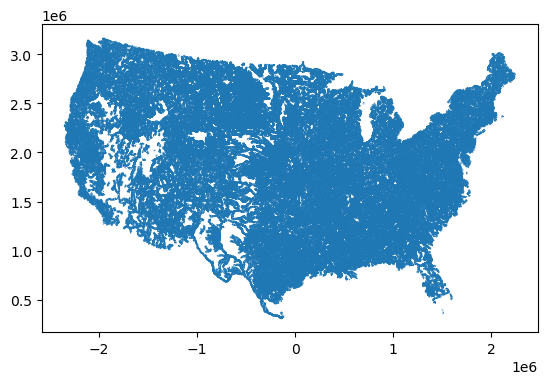

In [97]:
print(segments.head())
print(len(segments))
segments.plot()

What does the crosswalk look like?

In [98]:
seg_xwalk = pd.read_csv('/beegfs/CMIP6/jdpaul3/hydroviz_data/gis/nhm_segment_id_crosswalk.csv')
seg_xwalk

,seg_id,seg_id_nat
0,1,1
1,2,2
2,3,3
3,4,4
4,5,5
...,...,...
56455,56456,56456
56456,56457,56457
56457,56458,56458
56458,56459,56459


Not very illuminating. Are these columns equal?


In [99]:
seg_xwalk['seg_id'].tolist() == seg_xwalk['seg_id_nat'].tolist()

True

Alright, seems like a crosswalk is not necessary for segments. 

Now let's try the watersheds.

  region  hru_id_nat                                           geometry
0     17       93013  POLYGON ((-1661303.115 2221244.978, -1661298.6...
1     17       93014  MULTIPOLYGON (((-1532954.896 2215904.774, -153...
2     17       93015  POLYGON ((-1532985.250 2215875.115, -1532984.8...
3     17       93016  POLYGON ((-1546064.860 2230034.835, -1546065.0...
4     17       93017  POLYGON ((-1546065.114 2230081.069, -1546065.0...
109951


<Axes: >

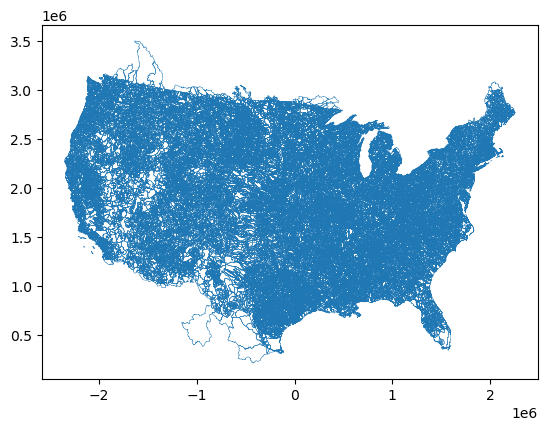

In [100]:
print(hrus.head())
print(len(hrus))
hrus.boundary.plot(linewidth=0.25)

OK this looks good, we definitely have the CONUS extent here, plus some watersheds that extend across the border. The number of polygons matches the number of rows in the stats data.

It's unclear if there are overlapping / hierarchical polygons (like "HUC12s inside of HUC8s" situation).

What about the crosswalk?

In [101]:
hru_xwalk = pd.read_csv('/beegfs/CMIP6/jdpaul3/hydroviz_data/gis/nhm_hru_id_crosswalk.csv')
hru_xwalk

,hru_id,hru_id_nat
0,1.0,2118.0
1,2.0,1865.0
2,3.0,1874.0
3,4.0,2108.0
4,5.0,2116.0
...,...,...
109946,109947.0,109379.0
109947,109948.0,109437.0
109948,109949.0,109450.0
109949,109950.0,109495.0


OK, this crosswalk seems to have more obvious value! We can directly relate these `hru_id_nat` values to NHM watershed IDs in the shapefiles found here: https://www.sciencebase.gov/catalog/item/5410bd38e4b07ab1cd98c45f